<div style="text-align: right">hidekuno@gmail.com<br>2021-02-28</div> 

# SICP 図形言語(numpy版)
   https://sicp.iijlab.net/fulltext/x224.html を参考にnumpyで実装

## matplot

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import cos
from math import sin
from math import pi

def draw_init():
    plt.axes().set_aspect('equal')
    plt.ylim([1, 0])
    plt.axis('off')

def draw_line(s,e):
    plt.plot([xcor_vect(s), xcor_vect(e)], [ycor_vect(s), ycor_vect(e)], 'black',linewidth=0.8)

## フレームの構築子
$$
\mathrm{MakeFrame}(origin,edge1, edge2) =
\mathrm{MakeFrame}(MakeVect(x_1,y_1),MakeVect(x_2,y_2), MakeVect(x_3,y_3))
$$

In [2]:
def make_frame(origin, edge1, edge2): return np.array([origin, edge1, edge2])
def origin_frame(frame):return frame[0]
def edge1_frame(frame): return frame[1]
def edge2_frame(frame): return frame[2]

## ベクトルの構築子
$$
\mathrm{MakeVect}(x,y) =
\begin{cases}
 x: \quad 0 \leqq x \leqq 1.0 \\
 y: \quad 0 \leqq y \leqq 1.0 \\
\end{cases}
$$

In [3]:
def make_vect(x, y): return np.array([x, y])
def xcor_vect(v): return v[0]
def ycor_vect(v): return v[1]

## フレーム内へベクタを写像

$(x_a, y_a) = Origin(Frame) + x*Edge_1(Frame) + y*Edge_2(Frame)$ = $(x_0, y_0) + s_x*(x_1, y_1) + s_y*(x_2, y_2$)

$$
\left[\begin{array}{c}
    x_a \\
    y_a
\end{array}\right]
=
\left[\begin{array}{c}
    x_0 \\
    y_0
\end{array}\right]
+
\left[\begin{array}{c}
    x_1 \\
    y_1
\end{array}\right]
*
s_x
+
\left[\begin{array}{c}
    x_2 \\
    y_2
\end{array}\right]
*
s_y
$$


In [4]:
def frame_coord_map(frame):
    return lambda v: origin_frame(frame) + xcor_vect(v) * edge1_frame(frame) + ycor_vect(v) * edge2_frame(frame)

## 新しいペインタの構築子
#### ペインタとフレームの変換法の情報をとり, 新しいペインタを作る

In [5]:
def transform_painter(painter, origin, corner1, corner2):
    def _lambda(frame):
        m = frame_coord_map(frame)
        new_origin = m(origin)
        return painter(make_frame(new_origin, m(corner1) - new_origin, m(corner2) - new_origin))                                  
    return _lambda

## ペインタの応用
##### 垂直反転
$$
\boldsymbol{v} =
\left[\begin{array}{c}
    0.0 & 1.0 \\
    1.0 & 1.0 \\
    0.0 & 0.0 \\
\end{array}\right]
$$

##### 水平反転
$$
\boldsymbol{v} =
\left[\begin{array}{c}
    1.0 & 0.0 \\
    0.0 & 0.0 \\
    1.0 & 1.0 \\
\end{array}\right]
$$

##### 90度回転
$$
\boldsymbol{v} =
\left[\begin{array}{c}
    1.0 & 0.0 \\
    1.0 & 1.0 \\
    0.0 & 0.0 \\
\end{array}\right]
$$

##### 270度回転
$$
\boldsymbol{v} =
\left[\begin{array}{c}
    0.0 & 1.0 \\
    0.0 & 0.0 \\
    1.0 & 1.0 \\
\end{array}\right]
$$

##### 右上の四半分に画像を縮める
$$
\boldsymbol{v} =
\left[\begin{array}{c}
    0.5 & 0.5 \\
    1.0 & 0.5 \\
    0.5 & 0.0 \\
\end{array}\right]
$$

In [6]:
def flip_vert(painter):
      return transform_painter(painter,
                               make_vect(0.0, 1.0),
                               make_vect(1.0, 1.0),
                               make_vect(0.0, 0.0))

def flip_horiz(painter):
      return transform_painter(painter,
                               make_vect(1.0, 0.0),
                               make_vect(0.0, 0.0),
                               make_vect(1.0, 1.0))

def rotate90(painter):
      return transform_painter(painter,
                               make_vect(1.0, 0.0),
                               make_vect(1.0, 1.0),
                               make_vect(0.0, 0.0))

def rotate270(painter):
      return transform_painter(painter,
                               make_vect(0.0, 1.0),
                               make_vect(0.0, 0.0),
                               make_vect(1.0, 1.0))

def shrink_to_upper_right(painter):
      return transform_painter(painter,
                               make_vect(0.5, 0.5),
                               make_vect(1.0, 0.5),
                               make_vect(0.5, 0.0))

## ペインタの組合せ

In [7]:
def beside(painter1, painter2):
    split_point = make_vect(0.5, 0.0)
    paint_left = transform_painter(painter1,
                                   make_vect(0.0, 0.0),
                                   split_point,
                                   make_vect(0.0, 1.0))
    paint_right = transform_painter(painter2,
                                    split_point,
                                    make_vect(1.0, 0.0),
                                    make_vect(0.5, 1.0))
    def _lambda(frame):
        paint_left(frame)
        paint_right(frame)

    return _lambda

def below(painter1, painter2): return rotate90(beside(rotate270(painter1), rotate270(painter2)))

def up_split(painter, n):
    if n == 0:
        return painter
    else:
        smaller = up_split(painter, n - 1)
        return below(painter, beside(smaller, smaller))
    
def right_split(painter, n):
    if n == 0:
        return painter
    else:
        smaller = right_split(painter, n - 1)
        return beside(painter, below(smaller, smaller))    
    
def corner_split(painter, n):
    if n == 0:
        return painter
    else:
        up = up_split(painter, n - 1)
        right = right_split(painter, n - 1)
        top_left = beside(up, up)
        bottom_right = below(right, right)
        corner = corner_split(painter, n - 1)

        return beside(below(painter, top_left),
                    below(bottom_right, corner))

def square_limit(painter, n):
    quarter = corner_split(painter, n)
    half = beside(flip_horiz(quarter), quarter)
    return below(flip_vert(half), half)

## 線分の構築子と描画処理
$$
\mathrm{MakeSegment}(start, end) =
\mathrm{MakeSegment}(MakeVect(x_1,y_1),MakeVect(x_2,y_2))
$$

In [8]:
def make_segment(start, end): return np.array([start,end])
def start_segment(seg): return seg[0]
def end_segment(seg): return seg[1]

def segments_painter(segment_list):
    def _lambda(frame):
        m = frame_coord_map(frame)
        for segment in segment_list:
            draw_line(m(start_segment(segment)), m(end_segment(segment)))
    return _lambda

## 描画データ

In [9]:
def wave():
    segments = (
        make_segment(make_vect(0.35, 0.15) ,make_vect(0.4, 0)),
        make_segment(make_vect(0.65, 0.15) ,make_vect(0.6, 0)),
        make_segment(make_vect(0.35, 0.15) ,make_vect(0.4, 0.35)),
        make_segment(make_vect(0.65, 0.15) ,make_vect(0.6, 0.35)),
        make_segment(make_vect(0.6, 0.35)  ,make_vect(0.75, 0.35)),
        make_segment(make_vect(0.4, 0.35)  ,make_vect(0.3, 0.35)),
        make_segment(make_vect(0.75, 0.35) ,make_vect(1, 0.65)),
        make_segment(make_vect(0.6, 0.55)  ,make_vect(1, 0.85)),
        make_segment(make_vect(0.6, 0.55)  ,make_vect(0.75, 1)),
        make_segment(make_vect(0.5, 0.7)   ,make_vect(0.6, 1)),
        make_segment(make_vect(0.3, 0.35)  ,make_vect(0.15, 0.4)),
        make_segment(make_vect(0.3, 0.4)   ,make_vect(0.15, 0.6)),
        make_segment(make_vect(0.15, 0.4)  ,make_vect(0, 0.15)),
        make_segment(make_vect(0.15, 0.6)  ,make_vect(0, 0.35)),
        make_segment(make_vect(0.3, 0.4)   ,make_vect(0.35, 0.5)),
        make_segment(make_vect(0.35, 0.5)  ,make_vect(0.25, 1)),
        make_segment(make_vect(0.5, 0.7)   ,make_vect(0.4, 1)),)
    return segments_painter(segments)

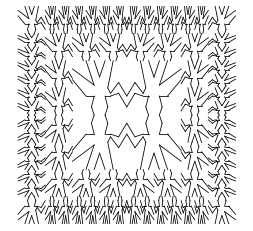

In [10]:
draw_init()
frame = make_frame(make_vect(0, 0),make_vect(1, 0),make_vect(0, 1))

#beside(wave(),wave())(frame)
#below(wave(),wave())(frame)
#up_split(wave(),1)(frame)
#right_split(wave(),1)(frame)
#corner_split(wave(),1)(frame)
square_limit(wave(),2)(frame)

## Koch曲線

##### a. 線分 [(x0,y0), (x1,y1)] を 1:2 に内分
$$
\left[\begin{array}{c}
    x_a \\
    y_a
\end{array}\right]
=
\left[\begin{array}{c}
    (x_0 * 2) + x_1 \\
    (y_0 * 2) + y_1
\end{array}\right]
*
\frac{1}{3}
$$

##### b. 線分 [(x0,y0), (x1,y1)] を 2:1 に内分
$$
\left[\begin{array}{c}
    x_b \\
    y_b
\end{array}\right]
=
\left[\begin{array}{c}
    (x_1 * 2) + x_0 \\
    (y_1 * 2) + y_0
\end{array}\right]
*
\frac{1}{3}
$$

#####  c. aとbより60度回転させる
$$
\left[\begin{array}{c}
    x_c \\
    y_c
\end{array}\right]
=
\left[\begin{array}{c}
    x_a \\
    y_a
\end{array}\right]
+
\left[\begin{array}{c}
    \cos \theta & -\sin \theta \\
    \sin \theta & \cos \theta
\end{array}\right]
\left[\begin{array}{c}
    (x_b - x_a) \\
    (y_b - y_a)
\end{array}\right]
$$


In [11]:
def make_matrix(a,b,c,d):
    return np.array([[a,b],[c,d]])

In [12]:
def koch(n):
    cs = cos((pi * 60) / 180)
    sn = sin((pi * 60) / 180)

    def _lambda(frame):
        def koch_iter(v0, v1, c):
            m =  frame_coord_map(frame)

            if c > 1:
                va = (v0 * 2 + v1) / 3
                vb = (v1 * 2 + v0) / 3
                vc = va + (make_matrix(cs,-sn,sn,cs) * (vb-va)).sum(axis=1)

                koch_iter(v0, va, c - 1)
                koch_iter(va, vc, c - 1)
                koch_iter(vc, vb, c - 1)
                koch_iter(vb, v1, c - 1)
            else:
                draw_line(m(v0), m(v1))

        va = make_vect(0.04722222222222222, 0.6964285714285714)
        vb = make_vect(0.6708333333333333, 0.6964285714285714)
        vc = va + (make_matrix(cs,sn,-sn, cs) * (vb-va)).sum(axis=1)

        koch_iter(vc,va,n)
        koch_iter(va,vb,n)
        koch_iter(vb,vc,n)
    return _lambda

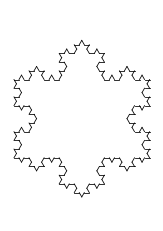

In [13]:
draw_init()
frame = make_frame(make_vect(0, 0),make_vect(1, 0),make_vect(0, 1))
transform_painter(koch(4),
                  make_vect(0.0, 0.0),
                  make_vect(1.0, 0.0),
                  make_vect(0.0, 1.0))(frame)

## ツリーカーブ

#####  右方向(回転)
$$
\left[\begin{array}{c}
    x_a \\
    y_a
\end{array}\right]
=
\left[\begin{array}{c}
    x_1 \\
    y_1
\end{array}\right]
+
\left[\begin{array}{c}
    \cos \theta & -\sin \theta \\
    \sin \theta & \cos \theta
\end{array}\right]
\left[\begin{array}{c}
    (x_1 - x_0) \\
    (y_1 - y_0) 
\end{array}\right]
$$
#####  左方向(逆回転)
$$
\left[\begin{array}{c}
    x_b \\
    y_b
\end{array}\right]
=
\left[\begin{array}{c}
    x_1 \\
    y_1
\end{array}\right]
+
\left[\begin{array}{c}
    \cos (-\theta) & -\sin (-\theta) \\
    \sin (-\theta) & \cos (-\theta)
\end{array}\right]
\left[\begin{array}{c}
    (x_1 - x_0) \\
    (y_1 - y_0) 
\end{array}\right]
=
\left[\begin{array}{c}
    x_1 \\
    y_1
\end{array}\right]
+
\left[\begin{array}{c}
    \cos \theta & \sin \theta \\
    -\sin \theta & \cos \theta
\end{array}\right]
\left[\begin{array}{c}
    (x_1 - x_0) \\
    (y_1 - y_0) 
\end{array}\right]
$$


In [14]:
def tree(n):
    def _lambda(frame):
        cs = cos((pi * 15) / 180)
        sn = sin((pi * 45) / 180)
        alpha = 0.6

        def tree_iter(v0, v1, c):
            m = frame_coord_map(frame)

            va = v1 + (make_matrix(cs,-sn,sn,cs) * (v1-v0) * alpha).sum(axis=1)
            vb = v1 + (make_matrix(cs,sn,-sn,cs) * (v1-v0) * alpha).sum(axis=1)

            draw_line(m(v0), m(v1))
            if  0 >= c:
                draw_line(m(v1), m(va))
                draw_line(m(v1), m(vb))
            else:
                tree_iter(v1, va, c - 1)
                tree_iter(v1, vb, c - 1)
        tree_iter(make_vect(0.4166666666666667, 0.7142857142857143),
                  make_vect(0.4166666666666667, 0.5357142857142857), n)
    return _lambda

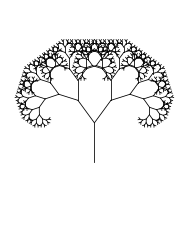

In [15]:
draw_init()
frame = make_frame(make_vect(0, 0),make_vect(1, 0),make_vect(0, 1))
transform_painter(tree(8),
                  make_vect(0.0, 0.0),
                  make_vect(1.0, 0.0),
                  make_vect(0.0, 1.0))(frame)